# Tennis Project

In [1]:
# Uncomment to install dependencies
# !pip -q install ./python

In [2]:
import numpy as np
from collections import deque
import torch

from agent import Agent

import matplotlib.pyplot as plt

from unityagents import UnityEnvironment
import numpy as np

# Change file_name to the place of your environment file
env = UnityEnvironment(file_name="./Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
n_agents = len(env_info.agents)

# size of each action
action_size = brain.vector_action_space_size

# size of each state
states = env_info.vector_observations
state_size = states.shape[1]

In [4]:
# Test the environment
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
for _ in range(5):
    actions = np.random.randn(n_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment


### Define the simulation function

In [5]:
def ddpg(agent, env, n_episodes=5000, train_mode=True):
    
    brain_name = env.brain_names[0]
    env_info = env.reset(train_mode=train_mode)[brain_name]
    n_agents = len(env_info.agents)
    
    scores_deque = deque(maxlen=100)
    scores = []

    for i_episode in range(1, n_episodes+1):
        
        env_info = env.reset(train_mode=train_mode)[brain_name]      # reset the environment
        states = env_info.vector_observations                        # get the current state (for each agent)
        agent.reset()
        
        score = np.zeros(n_agents)
        done = False
                
        while not done:

            actions = agent.act(states)

            actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            
            if train_mode:
                for i in range(n_agents):
                    agent.step(states[i], actions[i], rewards[i], next_states[i], dones[i],)
            
            states = next_states
            score += rewards
            done = True in dones
            
        scores_deque.append(np.max(score))
        scores.append(np.max(score))

        if train_mode:
            print('\r Episode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), np.max(score)), end="")
            if i_episode % 100 == 0:
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
                torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
                print('\r Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            if np.mean(scores_deque) >= 0.5:
                break
        else:
            print(' Episode {}\tScore: {:.2f}'.format(i_episode, np.max(score)))
            

    return scores

### Train the agent

 Episode 100	Average Score: 0.00	Score: 0.00
 Episode 200	Average Score: 0.00	Score: 0.00
 Episode 300	Average Score: 0.01	Score: 0.00
 Episode 400	Average Score: 0.00	Score: 0.00
 Episode 500	Average Score: 0.00	Score: 0.00
 Episode 600	Average Score: 0.01	Score: 0.00
 Episode 700	Average Score: 0.00	Score: 0.00
 Episode 800	Average Score: 0.01	Score: 0.09
 Episode 900	Average Score: 0.07	Score: 0.09
 Episode 1000	Average Score: 0.09	Score: 0.10
 Episode 1100	Average Score: 0.10	Score: 0.00
 Episode 1200	Average Score: 0.11	Score: 0.10
 Episode 1300	Average Score: 0.23	Score: 0.30
 Episode 1400	Average Score: 0.18	Score: 0.29
 Episode 1500	Average Score: 0.19	Score: 0.30
 Episode 1600	Average Score: 0.18	Score: 0.10
 Episode 1700	Average Score: 0.29	Score: 0.80
 Episode 1735	Average Score: 0.50	Score: 2.50

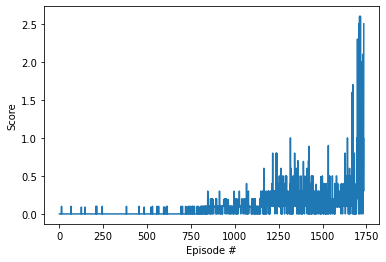

In [6]:
agent = Agent(state_size, action_size, num_agents=n_agents, update_every=n_agents)

scores = ddpg(agent, env)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Demo

In [ ]:
ddpg(agent, env, n_episodes=20, train_mode=False)

 Episode 1	Score: 0.20
 Episode 2	Score: 0.60
 Episode 3	Score: 0.40
 Episode 4	Score: 1.70
 Episode 5	Score: 0.00
 Episode 6	Score: 2.10
 Episode 7	Score: 1.10
 Episode 8	Score: 0.20
 Episode 9	Score: 0.00
 Episode 10	Score: 2.60
 Episode 11	Score: 0.00
 Episode 12	Score: 0.00
 Episode 13	Score: 0.10
 Episode 14	Score: 0.00
 Episode 15	Score: 0.50
 Episode 16	Score: 0.80
 Episode 17	Score: 1.80
 Episode 18	Score: 0.80


In [ ]:
# Close the environment
env.close()

In [ ]:
# plot the learning curve

# Compute the rolling average
rolling_avg = np.zeros(len(scores))
for i in range(99, len(scores)):
    rolling_avg[i] = np.mean(scores[i-99:i+1])

# Create a 16x9 figure
fig, ax = plt.subplots(figsize=(16,9))

# Plot both curves over the same axis
ax.plot(range(len(scores)), scores, label='Score', color='blue', alpha=0.75)
ax.plot(range(len(rolling_avg)), rolling_avg, label='Rolling average', color='red')
ax.axhline(0, color='black', alpha=0.3)
ax.axhline(0.5, color='green')

ax.set_title('Agent\'s score')
ax.legend()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('Score_over_train.png')
plt.show()